In [19]:
import numpy as np
import params as prm
from joblib import Parallel, delayed
from sklearn import preprocessing 
from lmfit import Model, Parameters
from tqdm import tqdm 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [20]:
timesteps = np.arange(-.2, .4, .01)
cluster_all = np.load("/home/alexandre/Documents/Decoding/postprocessing/data/paper_2023_postprocess/cluster_list.npy",allow_pickle = True)
winsize=.1
def load_neuron_data(cluster_path):
    spiketimes = np.load(prm.grouping_path + cluster_path + '/spiketimes.npy', allow_pickle = True)
    spiketimes = spiketimes / prm.fs
    seq_contents = np.load(prm.grouping_path + cluster_path + '/sequences_contents.npy', allow_pickle = True)

    return {'cluster_path' : cluster_path,
            'spiketimes' : spiketimes,
            'seq_contents' : seq_contents} 
def filter_neuron_data(data,
                    data_type, target_btheta, target_theta,
                    min_t, max_t):
    
    spiketimes = data['spiketimes']
    seq_contents = data['seq_contents']
    
    if data_type == 'one_bt':
        spikes = [len(np.where((spiketimes > (seq['sequence_beg'] / prm.fs) + min_t) &
                    (spiketimes < (seq['sequence_beg'] / prm.fs) + max_t))[0])
                    for seq in seq_contents
                    if seq['sequence_btheta'] == target_btheta]

    elif data_type == 'bt_decoding_one_t' :
        spikes = [len(np.where((spiketimes > (seq['sequence_beg'] / prm.fs) + min_t) &
                    (spiketimes < (seq['sequence_beg'] / prm.fs) + max_t))[0])
                    for seq in seq_contents
                    if seq['sequence_theta'] == target_theta]

    elif data_type in ['all_bt',  'all_t_bt', 'bt_decoding']:
        spikes = [len(np.where((spiketimes > (seq['sequence_beg'] / prm.fs) + min_t) &
                    (spiketimes < (seq['sequence_beg'] / prm.fs) + max_t))[0])
                    for seq in seq_contents]

    return {'cluster_path' : data['cluster_path'],
            'spikes' : spikes}
def par_load_data(timesteps, target_clusters, 
                data_type, target_btheta, target_theta,
                disable_tqdm = False):
    
    # Load the data from the disk
    loaded_data = Parallel(n_jobs = -1)(delayed(load_neuron_data)(cluster_path) for cluster_path in tqdm(target_clusters, desc = 'Loading data', disable = disable_tqdm))
    
    # Filter the data to get correct timestep and spikes
    if data_type == 'one_bt' : # décode
        last_shape = 30*12
    elif data_type == 'bt_decoding' :
        last_shape = 30*8*12
    elif data_type == 'all_t_bt' :
        last_shape = 30*8*12 # TODO is this correct ?
    out_data = np.zeros((len(timesteps), len(target_clusters), last_shape))
    for it, timestep in tqdm(enumerate(timesteps), total = len(timesteps), desc = 'Filtering data', disable = disable_tqdm):
        max_t = timestep + prm.win_size
        min_t = timestep 
        
        filtered_data = Parallel(n_jobs = -1)(delayed(filter_neuron_data)(data,
                                                                        data_type, target_btheta, target_theta,
                                                                        min_t, max_t) for data in loaded_data)
        

        if np.asarray(filtered_data[0]['spikes']).shape[0] != last_shape:
            print('Warning: the number of reptitions %s does not match last shape %s' %(np.asarray(filtered_data[0]['spikes']).shape, last_shape))
            
        # And reformat to array to follow the same ordering as target_clusters
        for ineuron, data in enumerate(filtered_data):
            idx_match = np.where(data['cluster_path'] == target_clusters)[0]
            out_data[it, idx_match] = data['spikes']
            
    out_data = np.swapaxes(out_data, 1, -1) # swap the reptition and neuron axis, otherwise bug
            
    # Now we get the labels, which is the easy part
    seq_contents_example = np.load(prm.grouping_path + target_clusters[0] + '/sequences_contents.npy', allow_pickle = True)
    if data_type == 'one_bt':
        labels = ['T%.3f'% seq['sequence_theta'] for seq in seq_contents_example
                if seq['sequence_btheta'] == target_btheta]

    elif data_type == 'all_t_bt':
        labels = ['BT%.3fT%.3f'%(seq['sequence_btheta'],seq['sequence_theta']) 
                for seq in seq_contents_example]

    elif data_type == 'bt_decoding' :
        labels = ['BT%.3f'% seq['sequence_btheta'] for seq in seq_contents_example]
        
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    
    return out_data, le.transform(labels), le

## Décoding $\mu_\theta$

clusters : ['Tom_BA01_cl58' 'Mary_A006_cl47' 'Steven_I002_cl49' 'Steven_AH01_cl126'
 'Steven_L001_cl149' 'Tom_I002_cl139' 'Tom_K001_cl141' 'Tom_I002_cl164'
 'Mary_A006_cl97' 'Steven_K001_cl88' 'Tom_M001_cl117' 'Tom_S001_cl82'
 'Tom_M002_cl147' 'Tom_X001_cl69' 'Mary_D005_cl39' 'Tom_T001_cl153'
 'Tom_J002_cl117' 'Mary_B004_cl25' 'Tom_H002_cl163' 'Mary_C006c_cl56'
 'Tom_Y001_cl183' 'Mary_C006a_cl76' 'Steven_L001_cl26'
 'Steven_AA002_cl192' 'Tom_I001_cl147' 'Steven_A001_cl187'
 'Steven_AF01_cl154' 'Mary_B004_cl127' 'Mary_C006d_cl69'
 'Steven_R001_cl123' 'Tom_M001_cl126' 'Mary_D005_cl138' 'Tom_C001_cl74'
 'Tom_H002_cl114' 'Mary_C006c_cl61' 'Steven_L001_cl137' 'Mary_C006a_cl62'
 'Tom_J002_cl28' 'Tom_I001_cl135' 'Tom_H001_cl97' 'Steven_L002_cl133'
 'Steven_I002_cl172' 'Steven_L001_cl104' 'Tom_I002_cl181' 'Tom_J001_cl121'
 'Mary_B004_cl47' 'Tom_J002_cl118' 'Steven_AI01_cl143' 'Tom_I001_cl117'
 'Steven_A001_cl129' 'Steven_U001_cl100' 'Tom_H001_cl93' 'Tom_R001_cl126'
 'Steven_Q001_cl151' 'Tom_C0

Filtering data: 100%|██████████| 61/61 [08:26<00:00,  8.30s/it]


shape data : (Orientation, Combinaison de stim, cluster) (61, 360, 249)
shape label : (Combinaison) (360,)


Decoding: 100%|██████████| 61/61 [01:09<00:00,  1.13s/it]


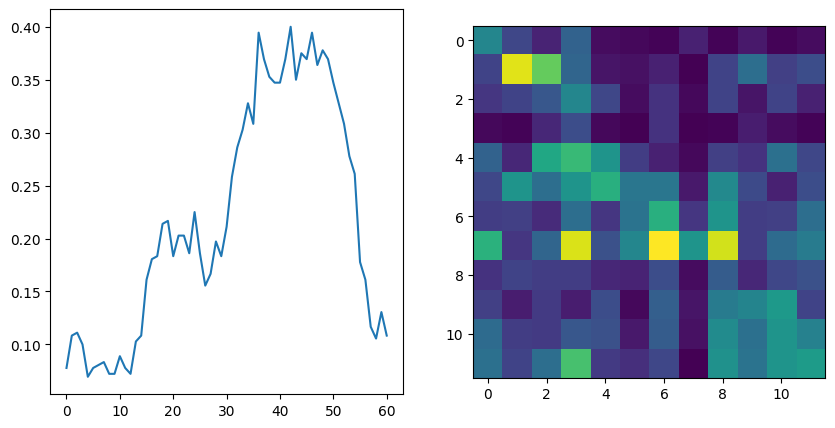

B_theta : 0.5385587406153931


Filtering data: 100%|██████████| 61/61 [08:30<00:00,  8.37s/it]


shape data : (Orientation, Combinaison de stim, cluster) (61, 360, 249)
shape label : (Combinaison) (360,)


Decoding: 100%|██████████| 61/61 [01:09<00:00,  1.14s/it]


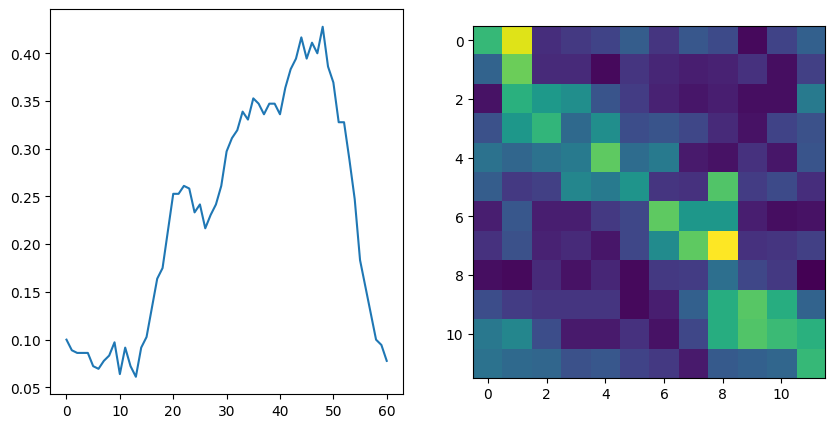

B_theta : 0.4487989505128276


Filtering data: 100%|██████████| 61/61 [08:31<00:00,  8.38s/it]


shape data : (Orientation, Combinaison de stim, cluster) (61, 360, 249)
shape label : (Combinaison) (360,)


Decoding: 100%|██████████| 61/61 [01:10<00:00,  1.15s/it]


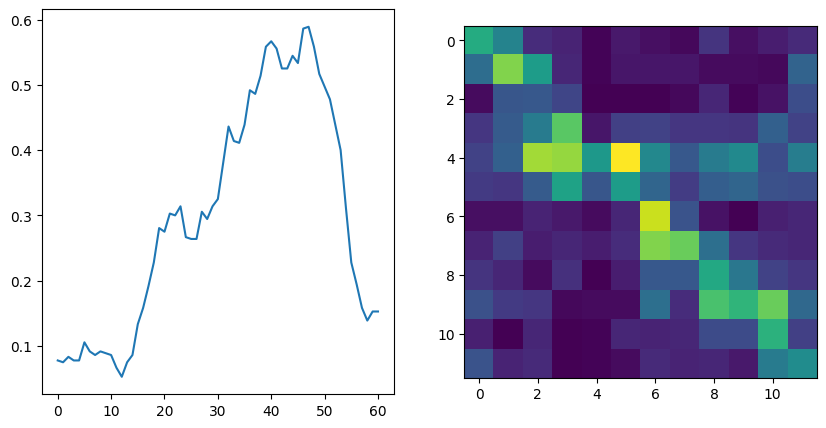

B_theta : 0.35903916041026207


Filtering data: 100%|██████████| 61/61 [08:19<00:00,  8.18s/it]


shape data : (Orientation, Combinaison de stim, cluster) (61, 360, 249)
shape label : (Combinaison) (360,)


Decoding: 100%|██████████| 61/61 [01:11<00:00,  1.17s/it]


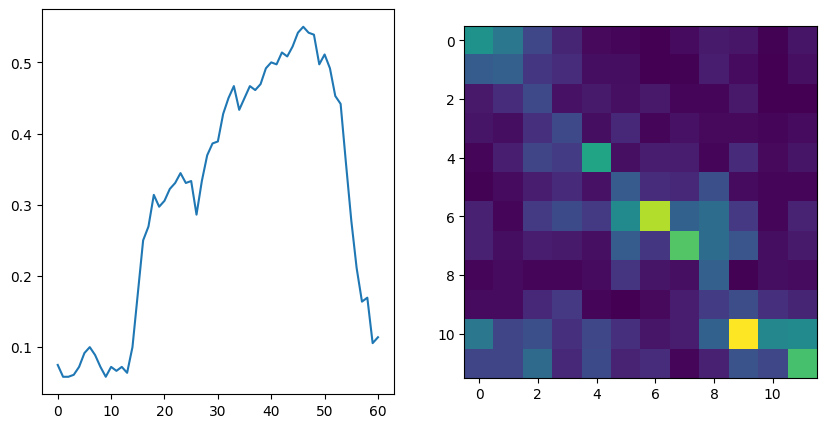

B_theta : 0.26927937030769655


Filtering data: 100%|██████████| 61/61 [08:32<00:00,  8.40s/it]


shape data : (Orientation, Combinaison de stim, cluster) (61, 360, 249)
shape label : (Combinaison) (360,)


Decoding: 100%|██████████| 61/61 [01:10<00:00,  1.16s/it]


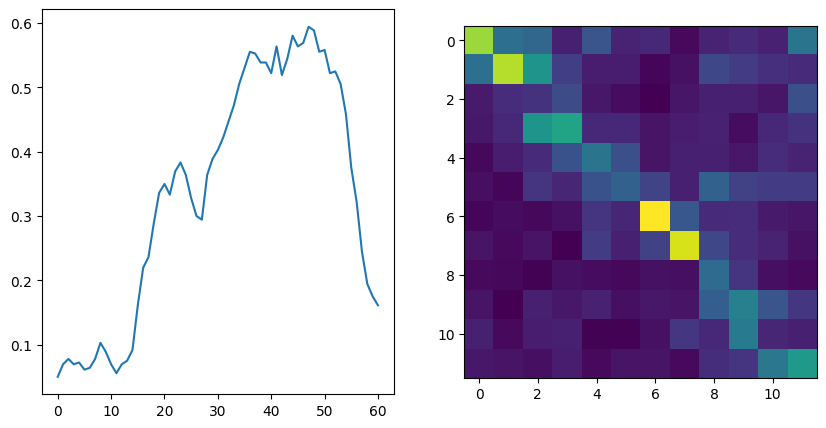

B_theta : 0.17951958020513104


Filtering data: 100%|██████████| 61/61 [08:29<00:00,  8.35s/it]


shape data : (Orientation, Combinaison de stim, cluster) (61, 360, 249)
shape label : (Combinaison) (360,)


Decoding: 100%|██████████| 61/61 [01:14<00:00,  1.22s/it]


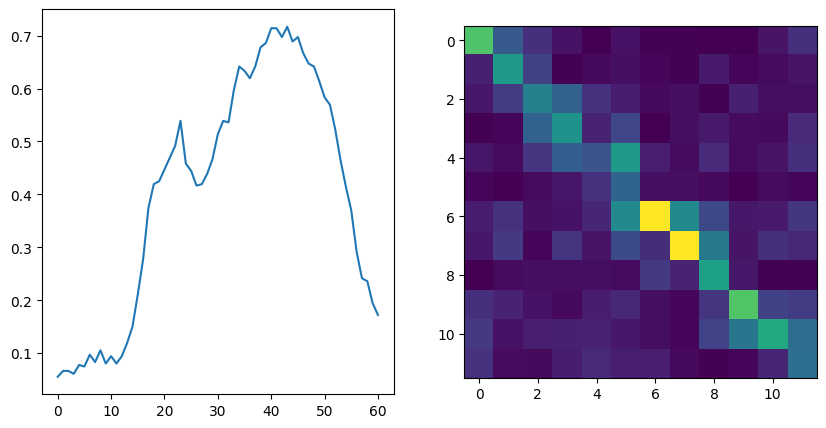

B_theta : 0.08975979010256552


Filtering data: 100%|██████████| 61/61 [08:35<00:00,  8.45s/it]


shape data : (Orientation, Combinaison de stim, cluster) (61, 360, 249)
shape label : (Combinaison) (360,)


Decoding: 100%|██████████| 61/61 [01:14<00:00,  1.23s/it]


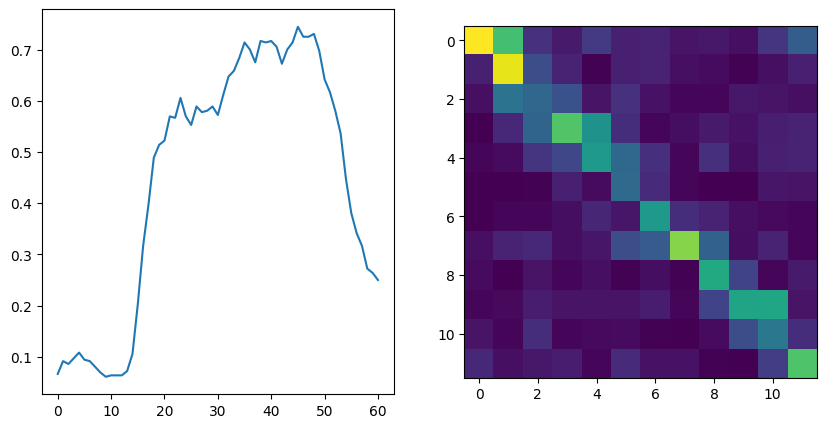

B_theta : 0.0


Filtering data: 100%|██████████| 61/61 [08:34<00:00,  8.43s/it]


shape data : (Orientation, Combinaison de stim, cluster) (61, 360, 249)
shape label : (Combinaison) (360,)


Decoding: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


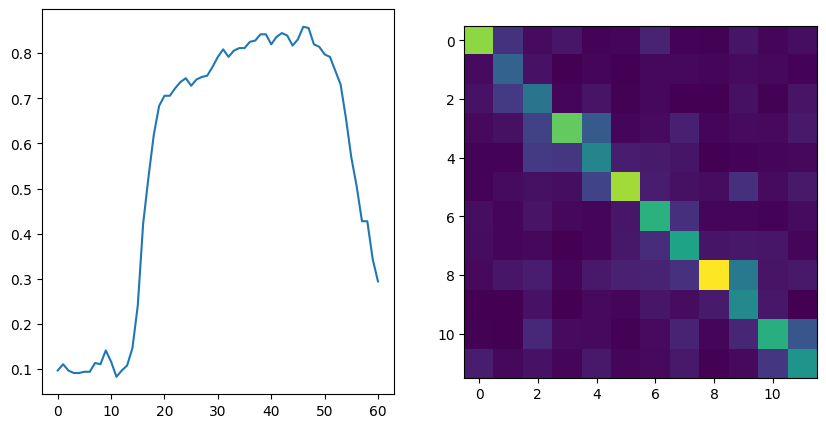

In [21]:
cluster=cluster_all
data_max=10
nbr_bin=10
print(f"clusters : {cluster}")
Matrice=np.zeros((12,12,len(prm.B_thetas)))
Scores_mean=np.zeros((61,len(prm.B_thetas)))
Scores_sd=np.zeros((61,len(prm.B_thetas)))
for j in range(len(prm.B_thetas)):
    bt=prm.B_thetas[j]
    print(f"B_theta : {bt}")
    data, labels, le = par_load_data(timesteps=timesteps, target_clusters=cluster,
                                            target_btheta=bt, target_theta=None,
                                            data_type="one_bt")
    print("shape data : (Orientation, Combinaison de stim, cluster)",np.shape(data))
    print("shape label : (Combinaison)", np.shape(labels))

    #Début égalisation
    #Distribution des données
    distrib_data,bin_data=np.histogram(data,bins=nbr_bin,range=(0,data_max),density=True)
    bin_mid_data=1/2*(np.sum((bin_data[1:],bin_data[:-1]),axis=0))
    #Probabilité cumulative
    Cumul_distrib=np.cumsum(distrib_data)
    #Interpolation
    data_interp=np.interp(data,bin_data[:-1],Cumul_distrib)
    #Fin égalisation
    
    matrice=np.zeros((12,12,61))
    scores=np.zeros((len(prm.timesteps),prm.n_splits))
    logreg = LogisticRegression(**prm.opts_LR)
    for i in tqdm(range(data_interp.shape[0]), desc = 'Decoding'):
        scores[i,:] = cross_val_score(logreg, data_interp[i,:,:], labels, 
                                    cv = prm.n_splits,scoring = 'balanced_accuracy')
        xtrain, xtest, ytrain, ytest = train_test_split(data_interp[i,:,:], labels, test_size=prm.test_size, random_state=42)
        logreg.fit(xtrain, ytrain)
        ypred=logreg.predict(xtest)
        matrice[:,:,i]=confusion_matrix(y_pred=ypred,y_true=ytest)
    Matrice[:,:,j]=matrice.mean(axis=-1)
    Scores_mean[:,j]=scores.mean(axis=-1)
    Scores_sd[:,j]=scores.std(axis=-1)

    fig,ax=plt.subplots(1,2,figsize=(10,5))
    ax[0].plot(scores.mean(axis=-1))
    ax[1].imshow(matrice.mean(axis=-1))
    plt.show()

In [23]:
#SAVE LES DONNEEES !!!!!
np.save('./data/Matrices_decoding_theta_equal.npy', [Matrice])
np.save('./data/Scores_mean_decoding_theta_equal.npy', [Scores_mean])
np.save('./data/Scores_sd_decoding_theta_equal.npy', [Scores_sd])

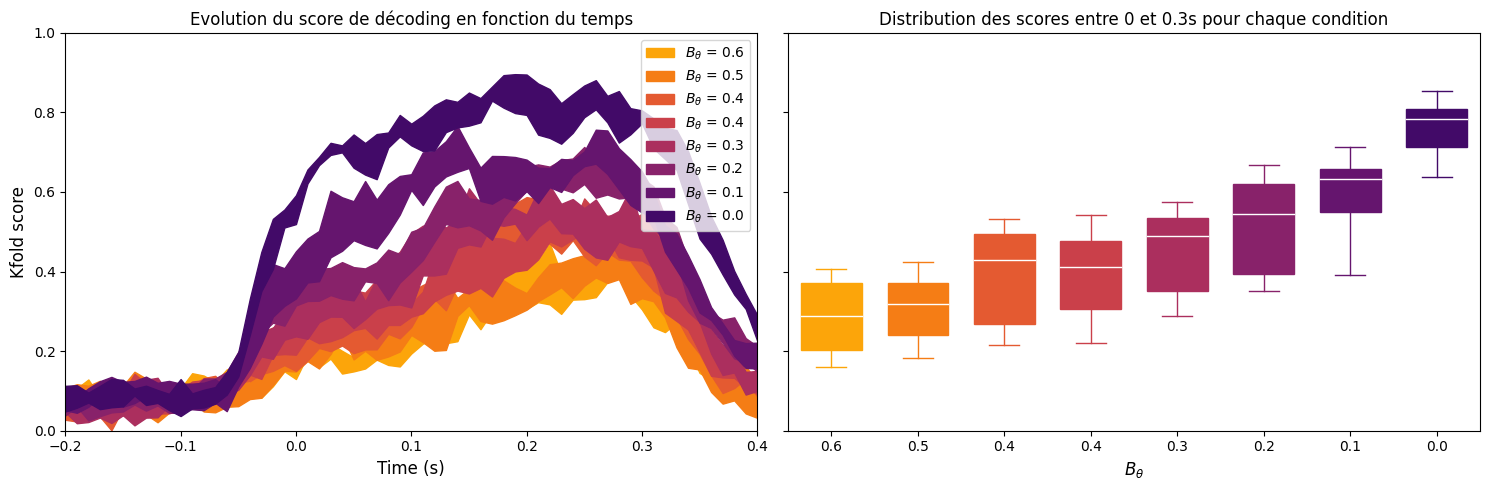

In [15]:
fig,ax=plt.subplots(1,2,figsize=(15,5),sharey=True)
for i in range(len(prm.B_thetas)):
    ax[0].fill_between(timesteps,Scores_mean[:,i]-Scores_sd[:,i],Scores_mean[:,i]+Scores_sd[:,i],color=prm.colors[i],label=r"$B_{\theta}$ = "+str(round(prm.B_thetas[i],1)))
    #ax[0].plot(timesteps,Scores_mean[:,i],"--",label=r"$B_{\theta}$ = "+str(round(prm.B_thetas[i],1)),color=prm.colors[i])
ax[0].set_xlim(timesteps.min(),timesteps.max())
ax[0].set_ylim(0,1)
ax[0].set_xlabel("Time (s)",size=12)
ax[0].set_ylabel("Kfold score",size=12)
ax[0].set_title("Evolution du score de décoding en fonction du temps",size=12)
ax[0].legend()

for i in range(len(prm.B_thetas)):
    ax[1].boxplot(Scores_mean[20:50,i],positions = [i],widths = 0.7, showmeans = False,showfliers = False,
                  patch_artist=True, boxprops=dict(facecolor=prm.colors[i], color=prm.colors[i]),
                  capprops=dict(color=prm.colors[i]), whiskerprops=dict(color=prm.colors[i]),
                  flierprops=dict(color=prm.colors[i], markeredgecolor=prm.colors[i]),
                  medianprops=dict(color='white'))
    
ax[1].set_xticklabels([round(prm.B_thetas[i],1) for i in range(len(prm.B_thetas))])
ax[1].set_xlabel(r"$B_{\theta}$",size=12)
ax[1].set_title("Distribution des scores entre 0 et 0.3s pour chaque condition",size=12)
plt.tight_layout()
plt.show()

In [16]:
print("(theta,theta, Btheta)",np.shape(Matrice))

(theta,theta, Btheta) (12, 12, 8)


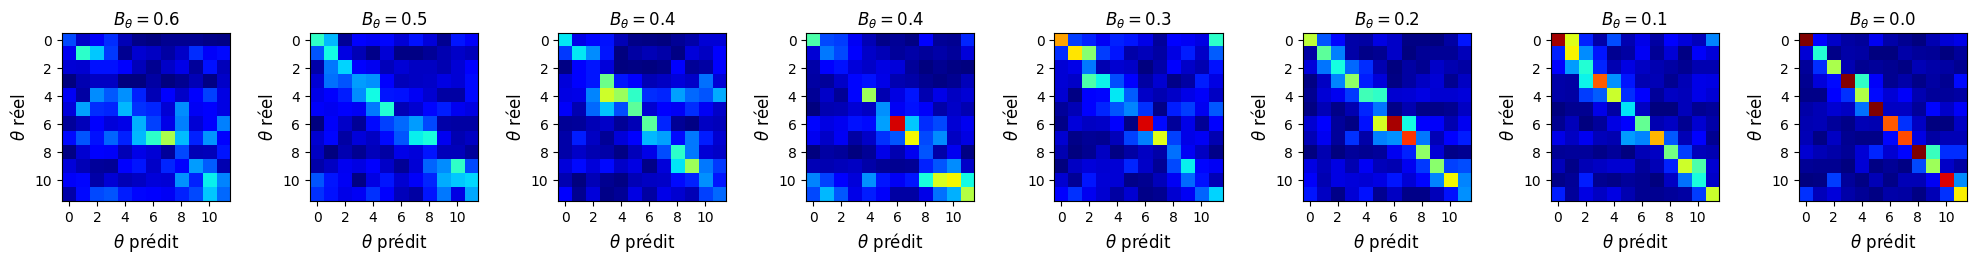

In [17]:
fig,ax=plt.subplots(1,8,figsize=(20,5))
for i in range(len(prm.B_thetas)):
    graph=ax[i].imshow(Matrice[:,:,i],vmin=0,vmax=3,cmap="jet")
    ax[i].set_title(r"$B_{\theta} = $"+str(round(prm.B_thetas[i],1)),size=12)
    ax[i].set_xlabel(r"$\theta$ prédit",size=12)
    ax[i].set_ylabel(r"$\theta$ réel",size=12)
    ax[i].set_xticks(range(0,11,2))
plt.tight_layout()
plt.show()

## Décoding $B_\theta$ :

clusters : ['Tom_BA01_cl58' 'Mary_A006_cl47' 'Steven_I002_cl49' 'Steven_AH01_cl126'
 'Steven_L001_cl149' 'Tom_I002_cl139' 'Tom_K001_cl141' 'Tom_I002_cl164'
 'Mary_A006_cl97' 'Steven_K001_cl88' 'Tom_M001_cl117' 'Tom_S001_cl82'
 'Tom_M002_cl147' 'Tom_X001_cl69' 'Mary_D005_cl39' 'Tom_T001_cl153'
 'Tom_J002_cl117' 'Mary_B004_cl25' 'Tom_H002_cl163' 'Mary_C006c_cl56'
 'Tom_Y001_cl183' 'Mary_C006a_cl76' 'Steven_L001_cl26'
 'Steven_AA002_cl192' 'Tom_I001_cl147' 'Steven_A001_cl187'
 'Steven_AF01_cl154' 'Mary_B004_cl127' 'Mary_C006d_cl69'
 'Steven_R001_cl123' 'Tom_M001_cl126' 'Mary_D005_cl138' 'Tom_C001_cl74'
 'Tom_H002_cl114' 'Mary_C006c_cl61' 'Steven_L001_cl137' 'Mary_C006a_cl62'
 'Tom_J002_cl28' 'Tom_I001_cl135' 'Tom_H001_cl97' 'Steven_L002_cl133'
 'Steven_I002_cl172' 'Steven_L001_cl104' 'Tom_I002_cl181' 'Tom_J001_cl121'
 'Mary_B004_cl47' 'Tom_J002_cl118' 'Steven_AI01_cl143' 'Tom_I001_cl117'
 'Steven_A001_cl129' 'Steven_U001_cl100' 'Tom_H001_cl93' 'Tom_R001_cl126'
 'Steven_Q001_cl151' 'Tom_C0

Filtering data: 100%|██████████| 61/61 [14:08<00:00, 13.91s/it]


shape data : (Orientation, Combinaison de stim, cluster) (61, 2880, 249)
shape label : (Combinaison) (2880,)


Decoding: 100%|██████████| 61/61 [16:52<00:00, 16.61s/it]


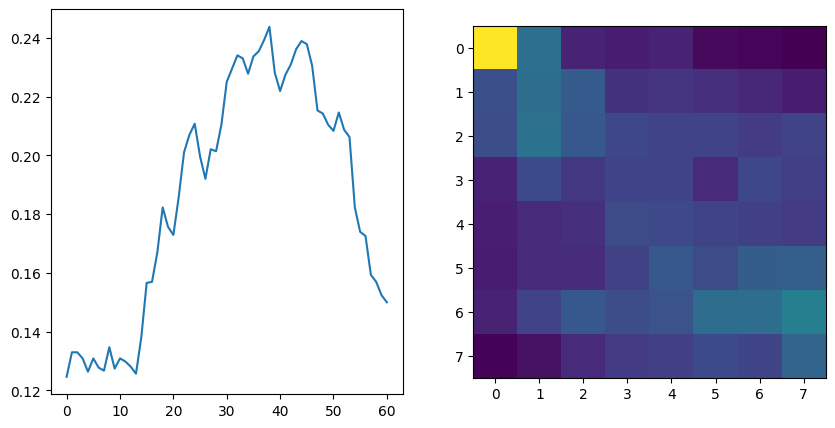

In [64]:
cluster=cluster_all
print(f"clusters : {cluster}")

Matrice=np.zeros((8,8))
Scores_mean=np.zeros((61))
Scores_sd=np.zeros((61))

data, labels, le = par_load_data(timesteps=timesteps, target_clusters=cluster,
                                        target_btheta=None, target_theta=None,
                                        data_type="bt_decoding")
print("shape data : (Orientation, Combinaison de stim, cluster)",np.shape(data))
print("shape label : (Combinaison)", np.shape(labels))
matrice=np.zeros((8,8,61))
scores=np.zeros((len(prm.timesteps),prm.n_splits))
logreg = LogisticRegression(**prm.opts_LR)
for i in tqdm(range(data.shape[0]), desc = 'Decoding'):
    scores[i,:] = cross_val_score(logreg, data[i,:,:], labels, 
                                cv = prm.n_splits,scoring = 'balanced_accuracy')
    xtrain, xtest, ytrain, ytest = train_test_split(data[i,:,:], labels, test_size=prm.test_size, random_state=42)
    logreg.fit(xtrain, ytrain)
    ypred=logreg.predict(xtest)
    matrice[:,:,i]=confusion_matrix(y_pred=ypred,y_true=ytest)
Matrice[:,:]=matrice.mean(axis=-1)
Scores_mean[:]=scores.mean(axis=-1)
Scores_sd[:]=scores.std(axis=-1)
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(scores.mean(axis=-1))
ax[1].imshow(matrice.mean(axis=-1))
plt.show()

In [67]:
#SAVE LES DONNEEES !!!!!
np.save('./data/Matrices_decoding_btheta.npy', [Matrice])
np.save('./data/Scores_mean_decoding_btheta.npy', [Scores_mean])
np.save('./data/Scores_sd_decoding_btheta.npy', [Scores_sd])

## Décoding $B_\theta$ and $\mu_\theta$ :

Filtering data: 100%|██████████| 61/61 [13:59<00:00, 13.76s/it]


shape data : (Orientation, Combinaison de stim, cluster) (61, 2880, 249)
shape label : (Combinaison) (2880,)


Decoding: 100%|██████████| 61/61 [1:13:51<00:00, 72.64s/it]


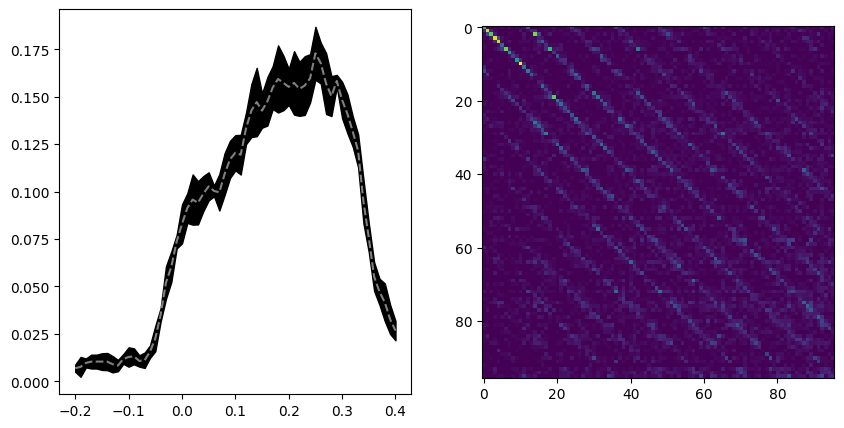

In [61]:
cluster=cluster_all
#print(f"clusters : {cluster}")

Matrice=np.zeros((8*12,8*12))
Scores_mean=np.zeros((61))
Scores_sd=np.zeros((61))

data, labels, le = par_load_data(timesteps=timesteps, target_clusters=cluster,
                                        target_btheta=None, target_theta=None,
                                        data_type="all_t_bt")
print("shape data : (Orientation, Combinaison de stim, cluster)",np.shape(data))
print("shape label : (Combinaison)", np.shape(labels))
matrice=np.zeros((8*12,8*12,61))
scores=np.zeros((len(prm.timesteps),prm.n_splits))
logreg = LogisticRegression(**prm.opts_LR)
for i in tqdm(range(data.shape[0]), desc = 'Decoding'):
    scores[i,:] = cross_val_score(logreg, data[i,:,:], labels, 
                                cv = prm.n_splits,scoring = 'balanced_accuracy')
    xtrain, xtest, ytrain, ytest = train_test_split(data[i,:,:], labels, test_size=0.2, random_state=42)  #test_size=prm.test_size
    logreg.fit(xtrain, ytrain)
    ypred=logreg.predict(xtest)
    matrice[:,:,i]=confusion_matrix(y_pred=ypred,y_true=ytest)
Matrice[:,:]=matrice.mean(axis=-1)
Scores_mean[:]=scores.mean(axis=-1)
Scores_sd[:]=scores.std(axis=-1)
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].fill_between(timesteps,scores.mean(axis=-1)-scores.std(axis=-1),scores.mean(axis=-1)+scores.std(axis=-1),color="black")
ax[0].plot(timesteps,scores.mean(axis=-1),linestyle="--",color="grey")
ax[1].imshow(matrice.mean(axis=-1))
plt.show()

In [62]:
#SAVE LES DONNEEES !!!!!  A refaire avec les matrices, erreures étrange de shape !
np.save('./data/Matrices_decoding_theta_btheta.npy', [Matrice])
np.save('./data/Scores_mean_decoding_theta_btheta.npy', [Scores_mean])
np.save('./data/Scores_sd_decoding_theta-btheta.npy', [Scores_sd])